In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_train = pd.read_csv('D:\\RnD\\Nets\\RNN\\data\\Google_Stock_Price_Train.csv')
train = data_train[['Open']].values

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

x_train = []
y_train = []
timesteps = 5
for i in range(timesteps, len(train_scaled)):
    x_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32)


In [3]:
class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=4):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [4]:
model = StockPriceRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [10/100], Loss: 0.083887
Epoch [20/100], Loss: 0.068305
Epoch [30/100], Loss: 0.032541
Epoch [40/100], Loss: 0.008184
Epoch [50/100], Loss: 0.001743
Epoch [60/100], Loss: 0.001325
Epoch [70/100], Loss: 0.000771
Epoch [80/100], Loss: 0.000660
Epoch [90/100], Loss: 0.000634
Epoch [100/100], Loss: 0.000624


In [6]:
data_test = pd.read_csv('D:\\RnD\\Nets\\RNN\\data\\Google_Stock_Price_Test.csv')
real_stock_price = data_test[['Open']].values

data_total = pd.concat((data_train['Open'], data_test['Open']), axis=0)
inputs = data_total[len(data_total) - len(data_test) - timesteps:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(timesteps, len(inputs)):
    x_test.append(inputs[i - timesteps:i, 0])
x_test = np.array(x_test)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(2)


In [7]:
model.eval()
with torch.no_grad():
    predicted_stock_price = model(x_test)
predicted_stock_price = predicted_stock_price.numpy()
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


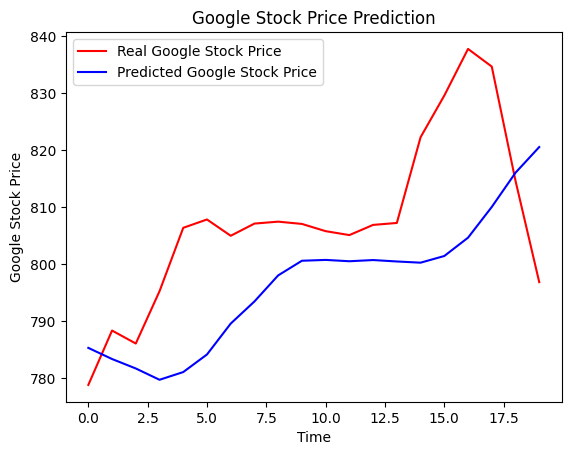

In [8]:
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()